In [40]:
import sys
from pathlib import Path
sys.path.append(Path(sys.path[0]).parent.as_posix())

import tensorflow as tf
import numpy as np
from environments.acrobot_cont_actions import AcrobotContActions
from CACLA import CACLA, training_step
from collections import deque
from tqdm.notebook import trange
import matplotlib.pyplot as plt

%matplotlib inline
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [41]:
env = AcrobotContActions()
reset_args = {
    "seed": 42,
    "options": {
        "low": -np.pi / 2,
        "high": np.pi / 2
    },
}
observation, info = env.reset(**reset_args)

model = CACLA(env.observation_space.shape, [1/np.pi, 1/np.pi, 1/env.MAX_VEL_1, 1/env.MAX_VEL_2], 12)

stddev = .3
discount_factor = 0.95
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-2)
loss_fn = tf.keras.losses.mean_squared_error

In [42]:
ex = np.array([.5, .5, .5, .5])[np.newaxis]
action, critic = model(ex)
print(f'Action: {action}')
print(f'Critic: {critic}')

Action: [[0.5704232]]
Critic: [[0.82551926]]


  0%|          | 0/5000 [00:00<?, ?it/s]

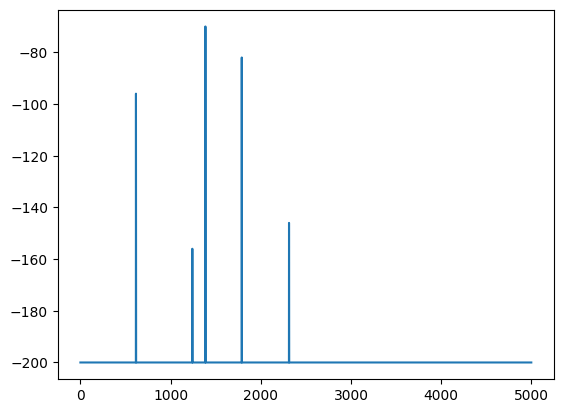

In [43]:
reward_sum_per_episode = []
n_episodes = 5000

for episode in trange(n_episodes):
    reward_sum = 0
    obs, _ = env.reset(**reset_args)
    for step in range(200):
        reward, done = training_step(env, model, stddev, discount_factor, optimizer, loss_fn)
        reward_sum += reward
        if done:
            break
    reward_sum_per_episode.append(reward_sum)

plt.plot(reward_sum_per_episode)

In [44]:
model.save_weights('CACLA_weights')